In [1]:
import os

import trax
from trax import data
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as np

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 


## Week 1: Neural Networks for Sentiment Analysis

trax vs thinc vs keras vs pytorch
- Lukasz, one of the 2 TAs is form Google Brain team. He was part of the TensorFlow team, then Translation team. Then he created the Tensor2Tensor library to make it fast and accessible to the wide public. Trax is the next evolution of Tensor2Tensor.
- very concise: makes implementation of papers very transparent
- trax runs on tensorflow backend and uses Jax t ospeed up computation (jax ~= enhanced version of numpy)
- keras is now part of TF from 2.0 onwards. trax is better for state of the art (transformers, reformers, BERT)
- layers look like objects (eg: tl.LayerNorm) but in fact they are functions

example of conciseness: 1 line for forward and backprop

In [ ]:
# https://www.tensorflow.org/datasets/catalog/ag_news_subset
train_stream = data.TFDS('ag_news_subset', keys=('description', 'label'), train=True)()
eval_stream = data.TFDS('ag_news_subset', keys=('description', 'label'), train=False)()

data_pipeline = data.Serial(
    data.Tokenize(vocab_file='en_8k.subword', keys=[0]),
    data.Shuffle(),
    data.FilterByLength(max_length=2048, length_keys=[0]),
    data.BucketByLength(boundaries=[  32, 128, 512, 2048],
                             batch_sizes=[512, 128,  32,    8, 1],
                             length_keys=[0]),
    data.AddLossWeights()
)
train_batches_stream = data_pipeline(train_stream)
eval_batches_stream = data_pipeline(eval_stream)

model = tl.Serial(
    tl.Embedding(vocab_size=8192, d_feature=50),
    tl.Mean(axis=1),
    tl.Dense(4),
    tl.LogSoftmax()
)

# Training task.
train_task = training.TrainTask(
    labeled_data=train_batches_stream,
    loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=500,
)

# Evaluaton task.
eval_task = training.EvalTask(
    labeled_data=eval_batches_stream,
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
    n_eval_batches=20  # For less variance in eval numbers.
)

# Training loop saves checkpoints to output_dir.
output_dir = os.path.expanduser('~/output-dir/')
!rm -rf {output_dir}
training_loop = training.Loop(model,
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

# Run 2000 steps (batches).
training_loop.run(2000)

In [ ]:
inputs, targets, weights = next(eval_batches_stream)

example_input = inputs[0]
expected_class = targets[0]
example_input_str = trax.data.detokenize(example_input, vocab_file='en_8k.subword')
print(f'example input_str: {example_input_str}')
sentiment_log_probs = model(example_input[None, :])  # Add batch dimension.
print(f'Model returned sentiment probabilities: {np.exp(sentiment_log_probs)}')
print(f'Expected class: {expected_class}')

## Week 2: RNNs for language modeling (as opposed to N-grams)

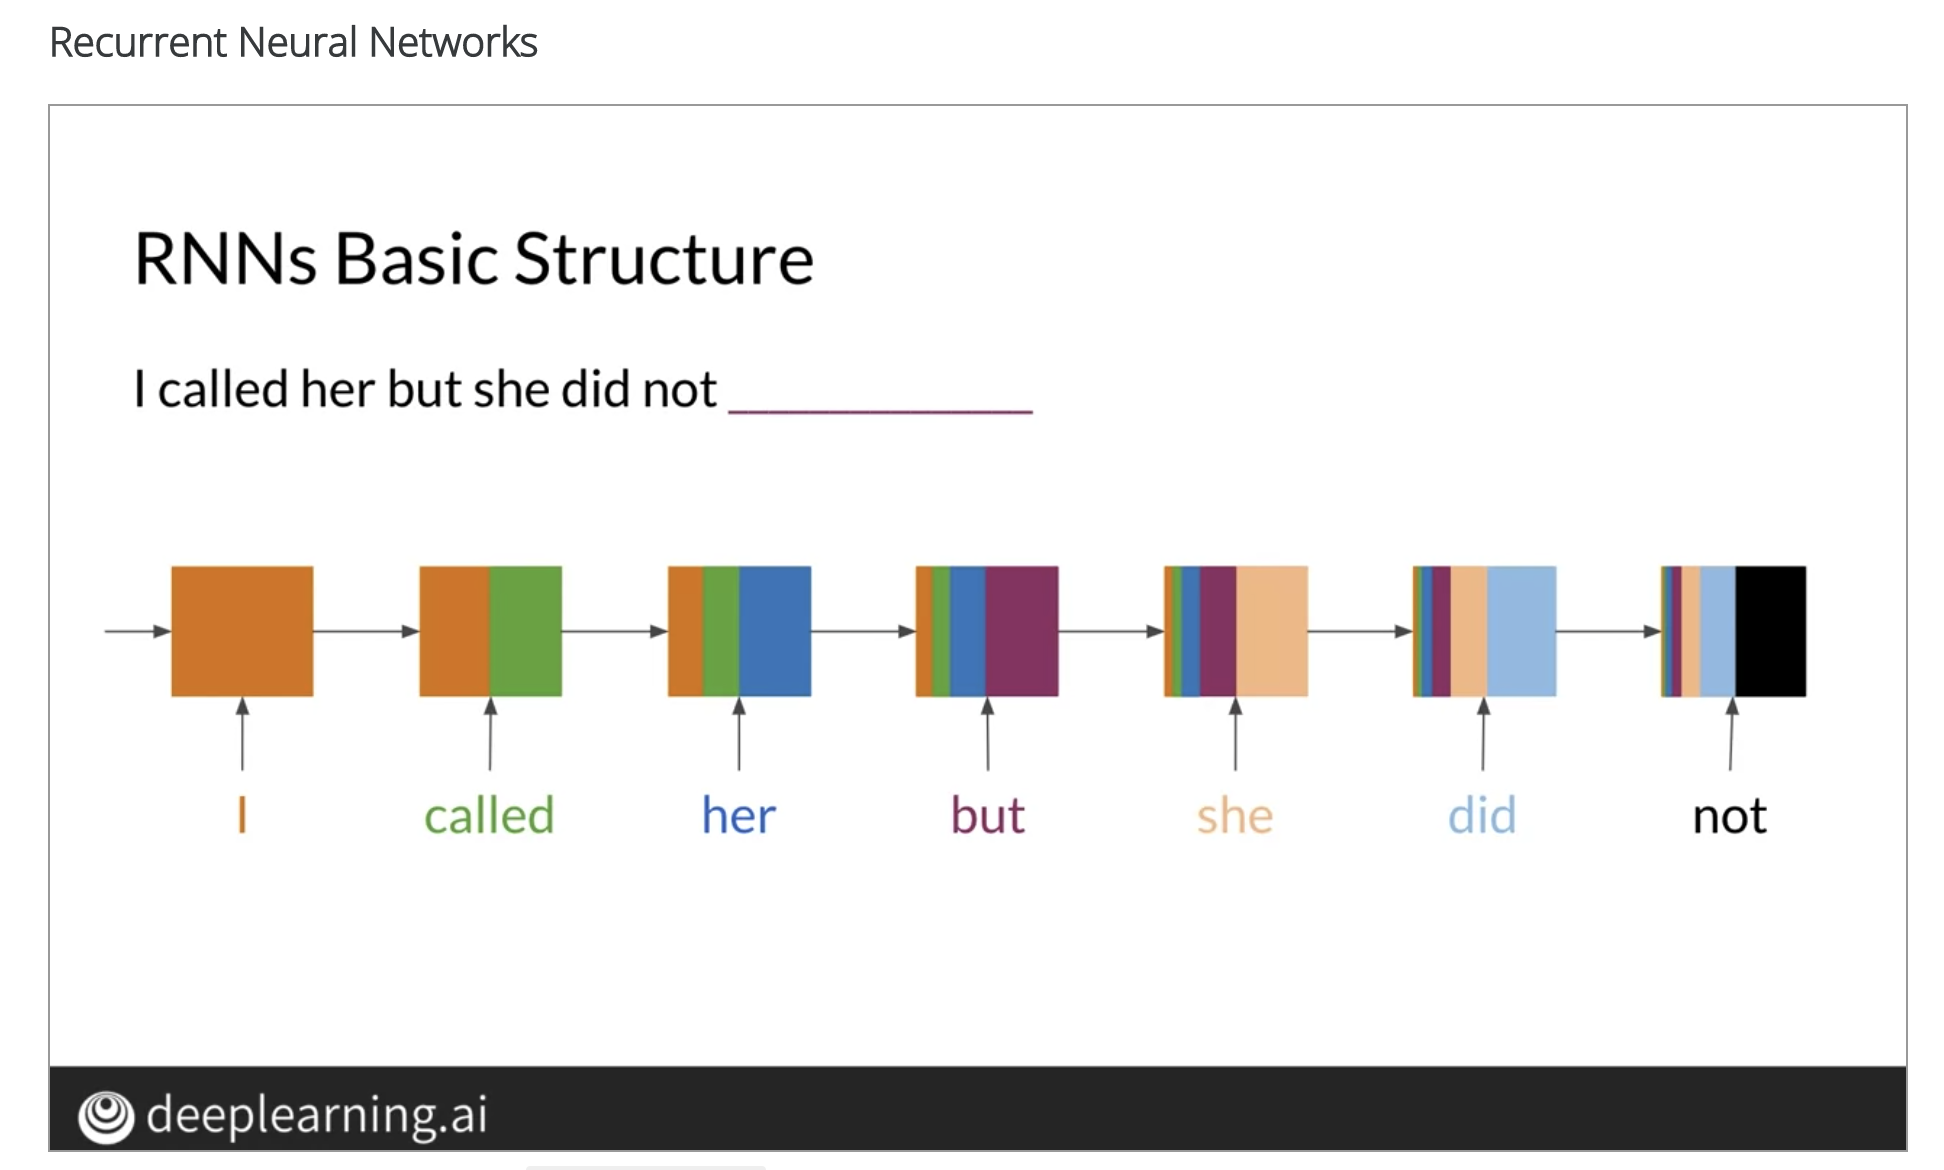

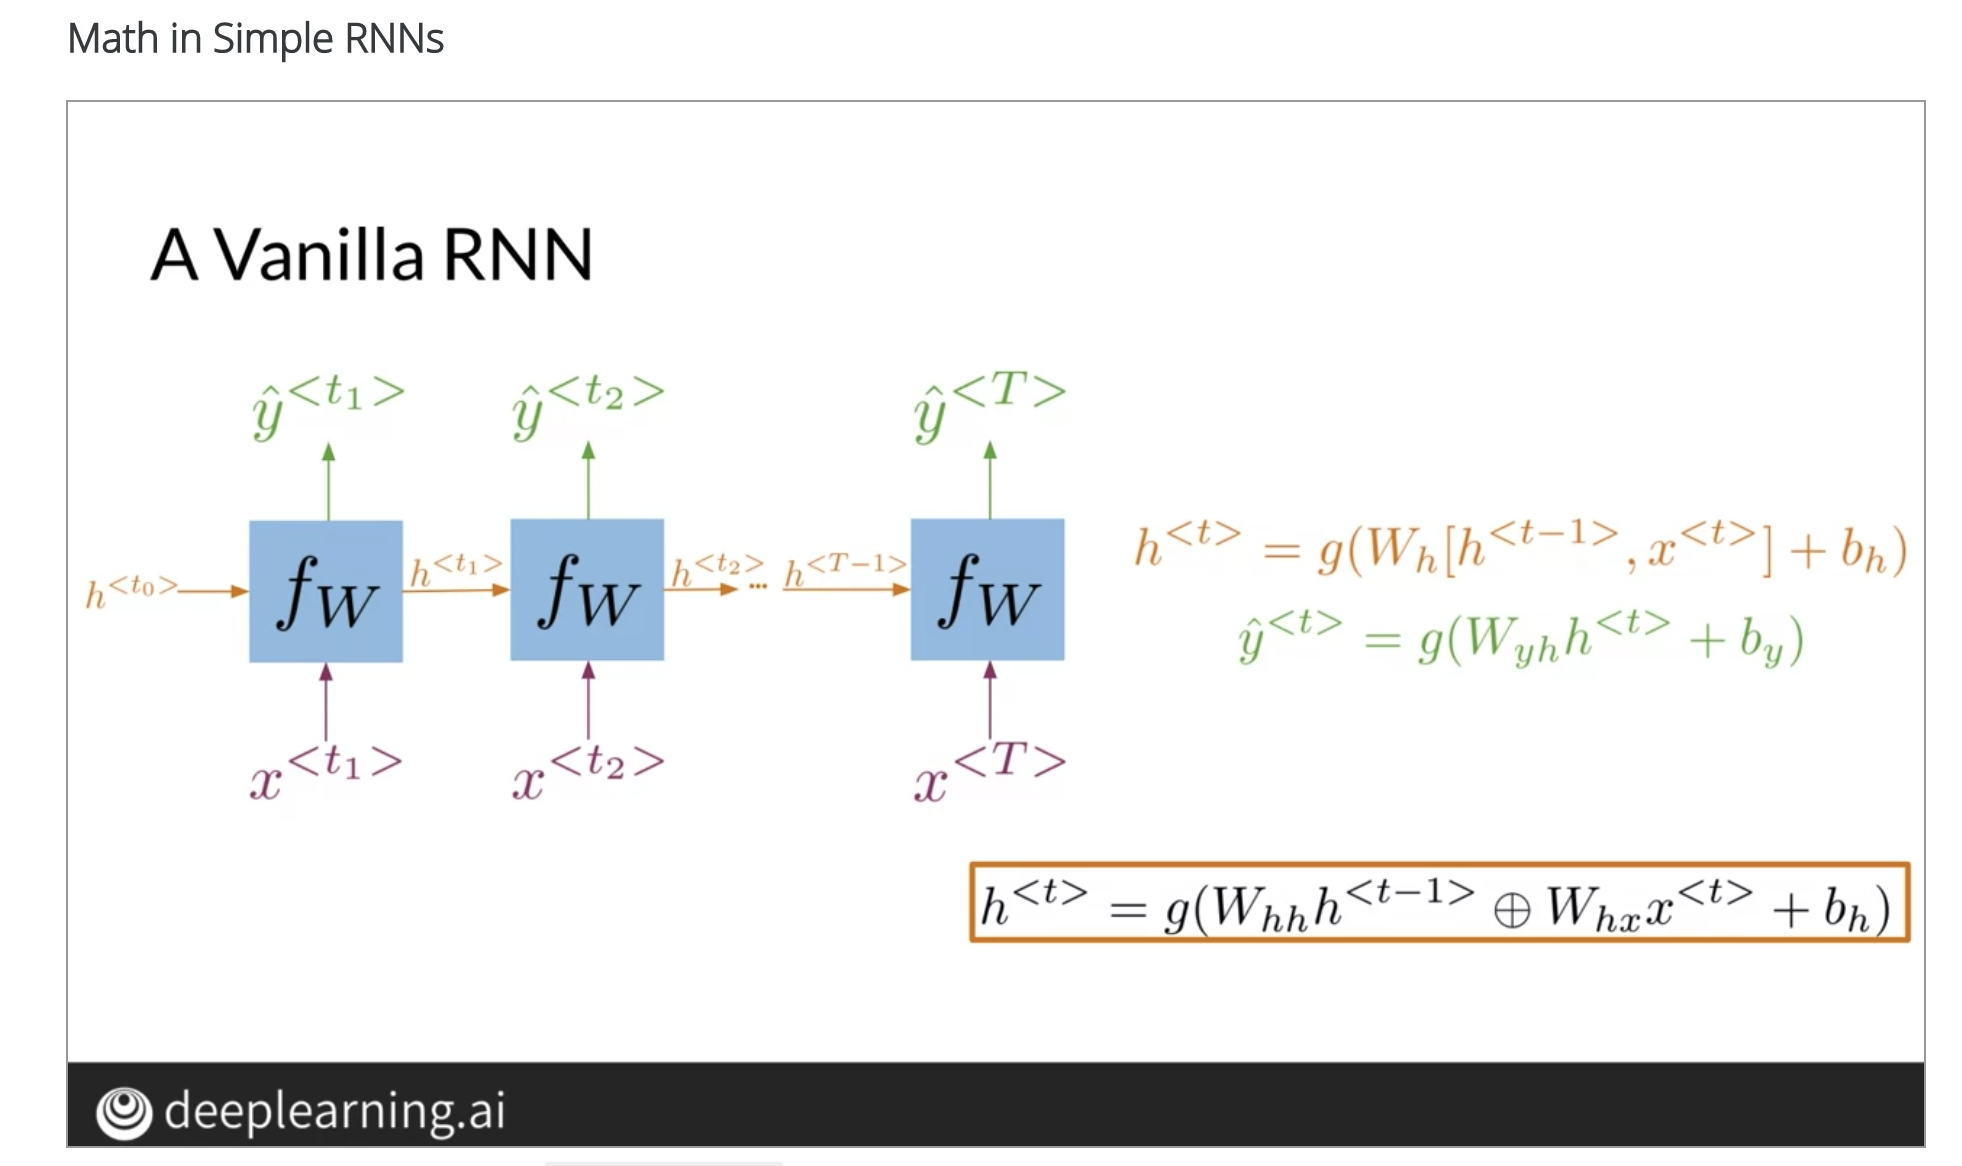

x = input at timestep t, y = prediction at timestep t, h = hidden state

The vanilla RNN cell is quite straight forward. Its most general structure is presented in the next figure: 

<img src="RNN.PNG" width="400"/>

As you saw in the lecture videos, the computations made in a vanilla RNN cell are equivalent to the following equations:

\begin{equation}
h^{<t>}=g(W_{h}[h^{<t-1>},x^{<t>}] + b_h)
\label{eq: htRNN}
\end{equation}
    
\begin{equation}
\hat{y}^{<t>}=g(W_{yh}h^{<t>} + b_y)
\label{eq: ytRNN}
\end{equation}

where $[h^{<t-1>},x^{<t>}]$ means that $h^{<t-1>}$ and $x^{<t>}$ are concatenated together. In the next cell we provide the implementation of the forward method for a vanilla RNN. 

- scan functions

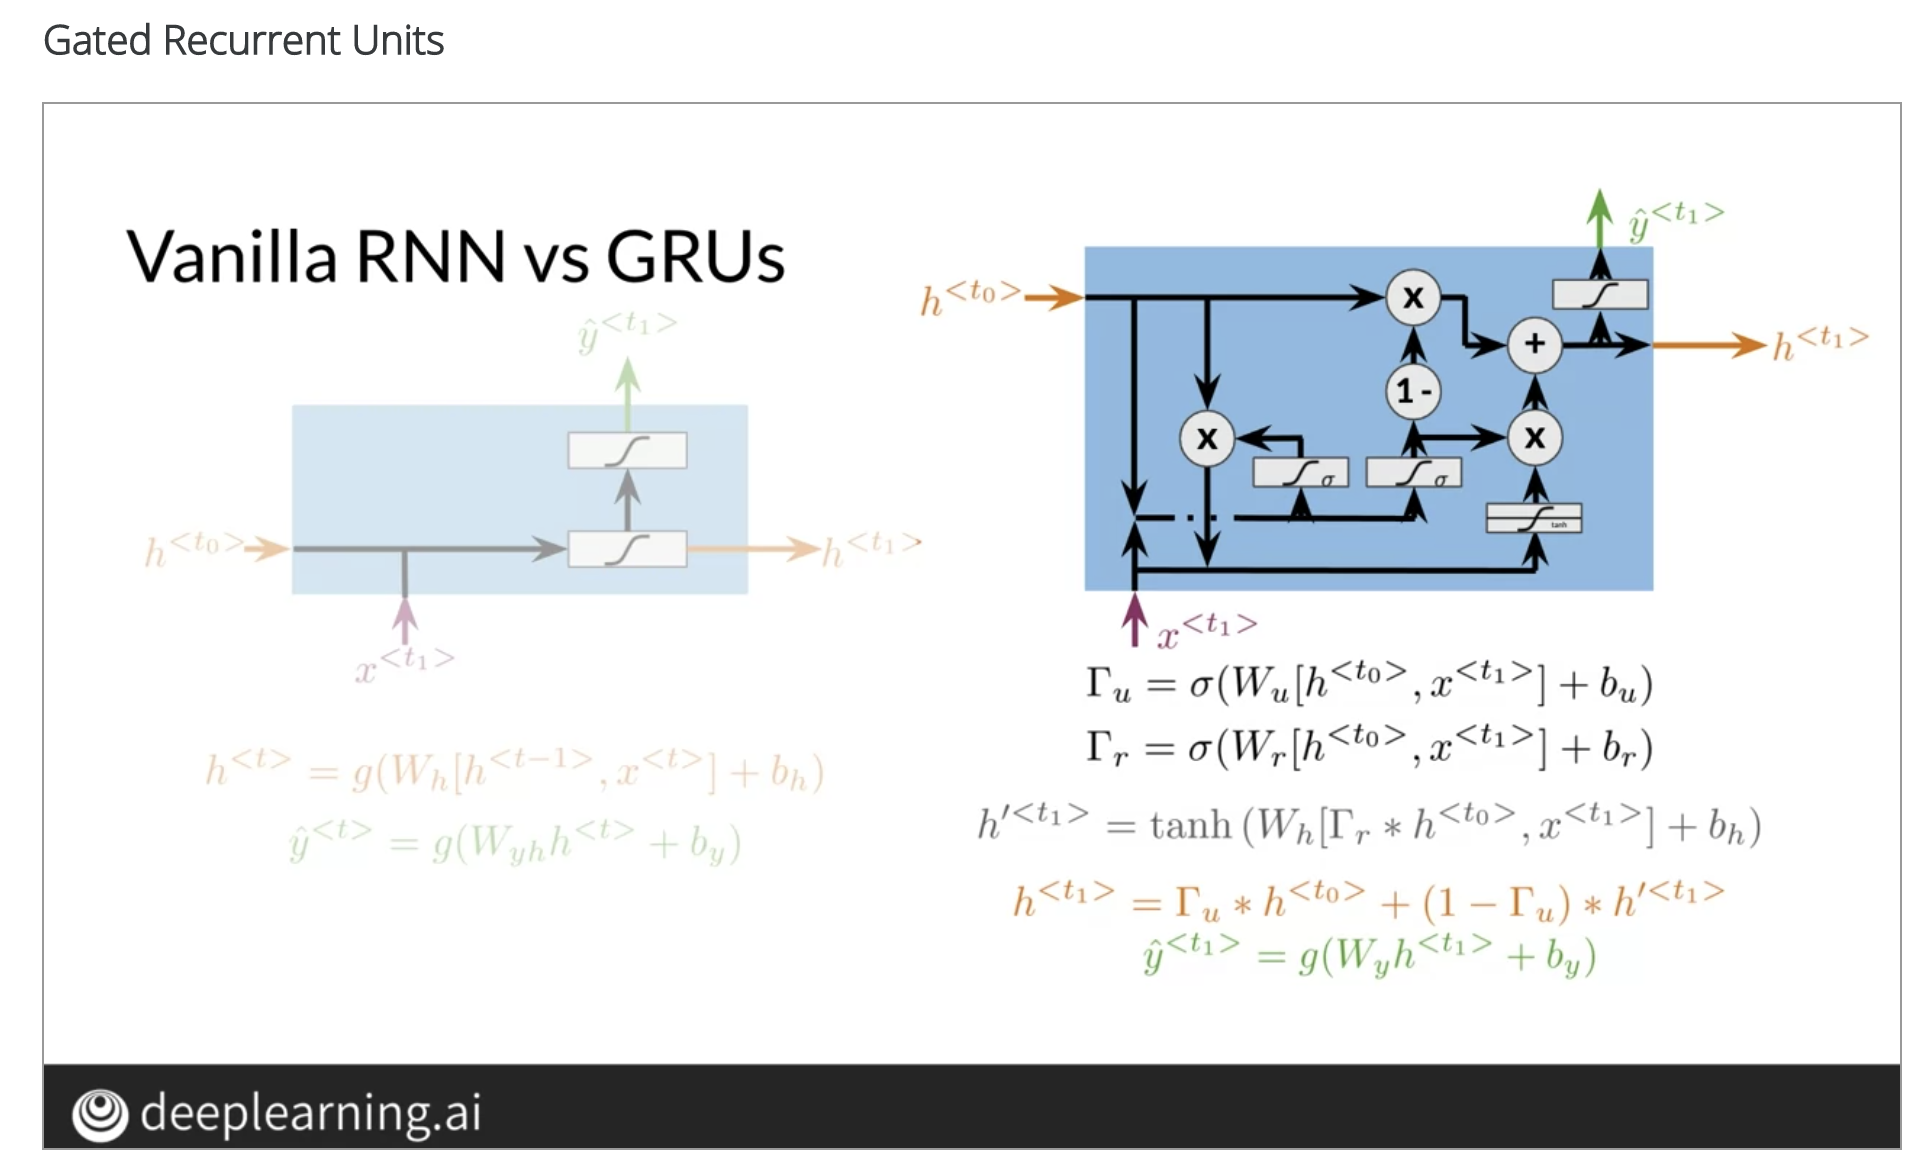

GRUs are simplified versions of LSTMs

A GRU cell have more computations than the ones that vanilla RNNs have. You can see this visually in the following diagram:

<img src="GRU.PNG" width="400"/>

As you saw in the lecture videos, GRUs have relevance $\Gamma_r$ and update $\Gamma_u$ gates that control how the hidden state $h^{<t>}$ is updated on every time step. With these gates, GRUs are capable of keeping relevant information in the hidden state even for long sequences. The equations needed for the forward method in GRUs are provided below: 

\begin{equation}
\Gamma_r=\sigma{(W_r[h^{<t-1>}, x^{<t>}]+b_r)}
\end{equation}

\begin{equation}
\Gamma_u=\sigma{(W_u[h^{<t-1>}, x^{<t>}]+b_u)}
\end{equation}

\begin{equation}
c^{<t>}=\tanh{(W_h[\Gamma_r*h^{<t-1>},x^{<t>}]+b_h)}
\end{equation}

\begin{equation}
h^{<t>}=\Gamma_u*c^{<t>}+(1-\Gamma_u)*h^{<t-1>}
\end{equation}

- `u` = update gate
- `r` = relevance gate
- `c` = candidate hidden state

### Assignment

- 125k sentences of Shakespear, with median length of 45. but then you discard lines longer than n characters (e.g. n = 32) so we end up with even less (25k lines)
- The model was only trained for 1 step due to the constraints of this coursera jupyterlab based environment. Even on a GPU accelerated environment it will take many hours for it to achieve a good level of accuracy.
- Train the deep-GRU (n_layers=2) model to predict the next character
- Generate language by drawing from the Gumble probability distribution

## Week 3: Entity Recognition with LSTMs

## Week 4: Siamese Networks